# Responsible Data Science Spring 2022: Homework 1

In [1]:
!git clone https://github.com/lurosenb/superquail
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.13.1
!pip install folktables

Cloning into 'superquail'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 1), reused 20 (delta 1), pack-reused 0
Unpacking objects: 100% (24/24), done.
     |████████████████████████████████| 165 kB 4.1 MB/s 
     |████████████████████████████████| 2.6 MB 5.1 MB/s 
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394770 sha256=3da263091a6c5c737b93d4be950468e27f86a41c4bd11e281dc789d2daf69d65
  Stored in directory: /root/.cache/pip/wheels/05/9f/ee/541a74be4cf5dad17430e64d3276370ea7b6a834a76cb4215a
Successfully built BlackBoxAuditing
     |████████████████████████████████| 92.6 MB 1.1 MB/s 
     |████████████████████████████████| 3.2 MB 39.2 MB/s 
     |████████████████████████████████| 367 kB 56.1 MB/s 
     |████████████████████████████████| 50 kB 5.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing install

In [2]:
import random
random.seed(27)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import json
import time 
from tqdm import tqdm

import matplotlib.pyplot as plt 
import seaborn as sns

from folktables import ACSDataSource, ACSEmployment, ACSIncome, ACSPublicCoverage, ACSTravelTime
from superquail.data.acs_helper import ACSData

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector


from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder


from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, RejectOptionClassification
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.explainers import MetricTextExplainer, Explainer

import BlackBoxAuditing
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# Problem 2
### **Load and split data** 

#### Load Folktables dataset and set the protected attribute, drop the other protected attribute race


We have included code to read in the folktables dataset. The Folktables dataset is taken from US Census Data and is built to solve a few simple prediction tasks. The sample we pull is data from 2018 in California. The column names are described in the table below. Note that certain categorical variables have been mapped to integer values, which we will keep as is for the following analyses.

For more information on the this dataset, please see the following paper:
https://eaamo2021.eaamo.org/accepted/acceptednonarchival/EAMO21_paper_16.pdf

| Column Name | Feature | Description/Notes |
| --- | ----------- | --- |
| PINCP | Total person’s income | (Target) 1 if >= $50k, 0 if less |
| SEX | Sex | (Sensitive Attribute) Male=1, Female=2 |
| RAC1P | Race | Dropped from this analysis to focus on one sensitive attribute |
| AGEP | Age | Ranges from 0-99 |
| COW | Class of Worker | Ranges 1-9, see paper for description |
| SCHL | Education Level | Ranges 1-24, see paper for description |
| MAR | Marital Status | Ranges 1-5, see paper for description |
| OCCP | Occupation | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| POBP | Place of Birth | Codes taken from Public Use Microdata Sample (PUMS) from the US Census, see paper |
| RELP | Relationship | Relationship of individual to person who responded to the Census taker. Ranges 0-17, see paper for description |
| WKHP | Hours worked per week | Ranges from 0-99, averaged over previous year |

In [3]:
np.random.seed(27)
protected_attr = 'SEX' #set sex as the protected attribute
target = 'PINCP' #personal income as the target (1=(>50k))

#read in the folktables dataset 
##change sample size back to 70 K later!!
full_df, features_df, target_df, groups_df = ACSData().return_acs_data_scenario(scenario="ACSIncome", subsample=50000)
full_df = full_df.drop(columns='RAC1P') #drop race -- another protected attribute from our dataset

print(full_df.shape)
full_df.head()

(5000, 10)


,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,PINCP
0,53.0,2.0,21.0,3.0,5400.0,233.0,15.0,30.0,1.0,0.0
1,51.0,2.0,21.0,1.0,350.0,217.0,0.0,40.0,2.0,1.0
2,45.0,6.0,21.0,1.0,4252.0,6.0,0.0,30.0,1.0,0.0
3,62.0,1.0,19.0,1.0,5140.0,48.0,0.0,40.0,2.0,0.0
4,63.0,6.0,19.0,1.0,4920.0,17.0,0.0,10.0,1.0,0.0


In [4]:
# convert this dataframe into an aif360 dataset
dataset_orig = BinaryLabelDataset(
    favorable_label=1,
    unfavorable_label=0,
    df=full_df,
    label_names=[target],
    protected_attribute_names=[protected_attr])


privileged_groups = [{protected_attr: 1}] 
unprivileged_groups = [{protected_attr: 2}]

### Create the train test val split

In [5]:
#split data into train_orig, containing 80% and test_orig
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True , seed= 27)
#create train_new and val_new, train_new has 70% of data, val_new has 10% of data, used for training and validation
train_new, val_new = train_orig.split([.875],shuffle=True)


# Convert to dataframes
train_orig_df, _ = train_orig.convert_to_dataframe()
train_new_df,_ =train_new.convert_to_dataframe()
val_new_df, _ = val_new.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()


#inspect shapes
print("Train set: ", train_new_df.shape)
print("Val set: ", val_new_df.shape)
print("Test set: ", test_orig_df.shape)



#examine baseline disparate impact and mean difference
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        train_orig,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact(),'\n',explainer_orig_panel19_train.mean_difference())

print('In our combined training and validation datasets, women receive a label of 1, 75%  as often as men')

Train set:  (3500, 10)
Val set:  (500, 10)
Test set:  (1000, 10)
Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.7334062461251832 
 Mean difference (mean label value on unprivileged instances - mean label value on privileged instances): -0.12665049526185895
In our combined training and validation datasets, women receive a label of 1, 75%  as often as men


# Problem 2, Part (a) 
### **Train a baseline Random Forest (RF) model and report metrics**

### Train a random forest model - Baseline





In [6]:
#create train and test vectors used for 
x_train, x_test = train_orig_df.drop(target, axis=1), test_orig_df.drop(target, axis=1)

y_train, y_test= train_orig_df.PINCP,  test_orig_df.PINCP

y_train.value_counts()

0.0    2332
1.0    1668
Name: PINCP, dtype: int64

In [7]:
#preprocess data using min max scalar and one hot encode variables
unmitigated_predictor = Pipeline(
    steps=[
           #feature engineering component 
        ("preprocessor", ColumnTransformer(transformers=[
                                              # we use selector to indentify features based on its data type
                                              # Normalize numerical features
                                               ("num", MinMaxScaler(), selector(dtype_exclude="category")), 
                                              # Encoding (transforming) categorical features to what understandable by the model
                                              ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                            ]
                                          )
        ),
        # model component
        ("classifier",RandomForestClassifier(max_depth = 1, n_estimators=1),
        ),
    ]
)
#fit predictor object on the training data
unmitigated_predictor.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f692cdc1f10>),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f692cdc1f90>)])),
                ('classifier',
                 RandomForestClassifier(max_depth=1, n_estimators=1))])

## Problem 2A:

Train a baseline Randomforest, with max_depth = 1 and num_estimators = 1 and report performance on the five metrics of interest on the test set.

In [1]:
#create new dataframe with predictions as the target column
test_pred_df = test_orig_df.copy()
test_pred_df[target] = unmitigated_predictor.predict(x_test)

#initiate a metric list to be used when examining metrics of interest
metric_list = ['accuracy','privileged_groups_accuracy', 'unprivileged_groups_accuracy','disparate_impact','false_positive_difference_rate']

#create AIF360 objects as input to a ClassificationMetric 
preds_aif360 = StandardDataset(test_pred_df, label_name=target,
                protected_attribute_names=[protected_attr], 
                privileged_classes=[[1]], favorable_classes=[1])

orig_aif360 = StandardDataset(test_orig_df, label_name=target,
                protected_attribute_names=[protected_attr], 
                privileged_classes=[[1]], favorable_classes=[1])

#store model performance in Classification metric Object
metrics_final = ClassificationMetric(orig_aif360, preds_aif360, 
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

NameError: name 'test_orig_df' is not defined

### Calculate Metrics

In [9]:
def calculate_metric(metric_list, ClassificationMetrObj, verbose):
    """
  function used to examine the 5 metrics of interest for ClassificationMetrObjects
  """
      for metric in metric_list:
        message = metric +' is '
          if metric == 'accuracy':
            statement = round(ClassificationMetrObj.accuracy(),5)
        elif metric == 'privileged_groups_accuracy':
            statement = round(ClassificationMetrObj.accuracy(privileged=True),5)
        elif metric == 'unprivileged_groups_accuracy':
            statement = round(ClassificationMetrObj.accuracy(privileged=False),5)
        elif metric == 'disparate_impact':
            statement = round(ClassificationMetrObj.disparate_impact(),5)
        else:
            statement = round(ClassificationMetrObj.false_positive_rate_difference(),5)
        if verbose == True:
            print(message + str(statement)) 
        return(statement)

In [10]:
#print statements to show model performance
calculate_metric(metric_list[0:],metrics_final, True)
calculate_metric(metric_list[1:],metrics_final, True)
calculate_metric(metric_list[2:],metrics_final, True)
calculate_metric(metric_list[3:],metrics_final, True)
calculate_metric(metric_list[4:],metrics_final, True)

accuracy is 0.605
privileged_groups_accuracy is 0.61731
unprivileged_groups_accuracy is 0.59167
disparate_impact is 0.84866
false_positive_difference_rate is -0.09328


-0.09328

# Problem 2, Part (b)
### **Hyperparameter tuning of baseline RF model**

### Define a program to conduct tune the Random Forest
Optimize the Accuracy. You should try the following hyperparameters: <br>
max_depth=[1, 5, 10] <br>
n_estimators=[1, 5, 10, 15, 20]

In [11]:
#YOUR CODE HERE

def tune_base_rf():
    """
  function that sequentially:
      creates a train/val/test datasplit  
      specifies a hyperparameters grid to iterate over using RandomSearchCV
      fits a model to each training dataset using a base model,
      validates optimal hyperparameters on the validation dataset
      captures test set performance for both models
      stores the results to a dictionary
      repeats this process 9 more times times
      outputs the dictionary of results
  """

  #initialize seed values used in data splitting
    seed_list = [27,100,65,12345,59,210398,4231,45,1,98753]

  #create gridSearchCV inputs
    max_depth_list = [1,5,10]
    n_estimators_list = [1,5,10,15,20]
    param_grid = [{'classifier__max_depth':max_depth_list,
                 'classifier__n_estimators':n_estimators_list
                 }]
  #dictionary that will be our final output
    run_dict = {}
    for i in range(len(seed_list)):

    #create an index for each run in our dictionary,
    #that corresponds to a nested dictionary
    run_dict[i] = {}


    #create splits for train,validation and test datasets
    train_orig, test_orig = dataset_orig.split([0.8], shuffle=True , seed= seed_list[i])
    train_new, val_new = train_orig.split([.875],shuffle=True, seed = seed_list[i])
   
    #create dataframe objects 
    train_orig_df, _ = train_orig.convert_to_dataframe()
    train_new_df,_ =train_new.convert_to_dataframe()
    val_new_df, _ = val_new.convert_to_dataframe()
    test_orig_df, _ = test_orig.convert_to_dataframe()

    #create vectors for base and tuned models

    x_base_train, x_base_test = train_orig_df.drop(target, axis=1), test_orig_df.drop(target, axis=1)
    y_base_train, y_base_test= train_orig_df.PINCP,  test_orig_df.PINCP


    x_val_train, x_val_test = train_new_df.drop(target, axis=1), val_new_df.drop(target, axis=1)
    y_val_train, y_val_test = train_new_df.PINCP, val_new_df.PINCP

    #create splits for hyperparameter tuning
    split_index = [-1 if x in x_val_train.index else 0 for x in x_base_train.index]
    pds = PredefinedSplit(test_fold = split_index)



    #create pipeline object
    unmitigated_predictor = Pipeline(
        steps=[
              #feature engineering component 
            ("preprocessor", ColumnTransformer(transformers=[
                                                  # we use selector to indentify features based on its data type
                                                  # Normalize numerical features
                                                  ("num", MinMaxScaler(), selector(dtype_exclude="category")), 
                                                  # Encoding (transforming) categorical features to what understandable by the model
                                                  ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                                ]
                                              )
            ),
            # model component
            ("classifier",RandomForestClassifier(max_depth = 1, n_estimators=1),
            ),
        ])
    
    #fit our base model on the training data, without using validation dataset
    
    unmitigated_predictor.fit(x_base_train, y_base_train)



    #create RandomizedSearhCV finding the optimized weights for this split on our validaiton data,
    clf = RandomizedSearchCV(unmitigated_predictor,
                         n_iter=10,
                         cv = pds,
                         scoring = 'accuracy',
                         param_distributions = param_grid)
    
    #fit the model with various hyperparameters on the training and validation dataset
    clf.fit(x_base_train,y_base_train)

    #capture the best accuracy and parameters of our tuned model
    run_dict[i]['max_validation_score'] = clf.best_score_
    run_dict[i]['params'] =clf.best_params_



    ##create dataframe objects that will be 
    base_pred_df = test_orig_df.copy()
    base_pred_df[target] = unmitigated_predictor.predict(x_base_test)
    tuned_pred_df = test_orig_df.copy()
    tuned_pred_df[target] = clf.predict(x_base_test)


    ##create AIF360 datasets 
    base_aif360 = StandardDataset(base_pred_df, label_name=target, protected_attribute_names=[protected_attr], 
                privileged_classes=[[1]], favorable_classes=[1])
    preds_aif360 = StandardDataset(tuned_pred_df, label_name=target, protected_attribute_names=[protected_attr], 
                privileged_classes=[[1]], favorable_classes=[1])
    orig_aif360 = StandardDataset(test_orig_df, label_name=target, protected_attribute_names=[protected_attr], 
                privileged_classes=[[1]], favorable_classes=[1])

    #create the classification metric object to store
    metrics_tuned = ClassificationMetric(orig_aif360, preds_aif360, unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
    metrics_base = ClassificationMetric(orig_aif360, base_aif360, unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
   
    #store the classificatoin metric objects in our dictionary
    run_dict[i]['base_metric'] = metrics_base
    run_dict[i]['tuned_metric'] = metrics_tuned
    return(run_dict)



### Compare the initial model to the fine-tuned model for 10 train/val/test splits for Random Forest

In [20]:
def compute_metric_lists(dict, metric_list, repair):
  """
  Args:
    dict -- a dictionary containing ClassificationMetric Objects that we will use to evaluate model metrics of interest
    metric_list -- a list of the metrics we want to evaluate 
    repair -- a boolean that indicates if the metrics we are interested in are a result of the repairing process, 
    which has a different input structure than the other problems

  returns: a dictionary of the metrics of interest for problems 2b-2e

  """
    if repair == False:
    initial_metric_dict, tuned_metric_dict = {}, {}
    for metric in metric_list:
        initial_metric_dict[metric] = []
        tuned_metric_dict[metric] = []

    """
    used for the tuning vs non tuning metric evaluation (2b/2)

    """
    for k,v in dict.items():
        if 'base_metric' in v.keys():
            for metric in metric_list:
                initial_metric_dict[metric].append(calculate_metric([metric],v['base_metric'],verbose=False))
                tuned_metric_dict[metric].append(calculate_metric([metric],v['tuned_metric'],verbose=False))
        else:

             """
             used for the ROC metric evaluation (2e)

             """
            for metric in metric_list:
                tuned_metric_dict[metric].append(calculate_metric([metric],v['metric_list'],verbose=False))
            if initial_metric_dict:
                return(initial_metric_dict,tuned_metric_dict)
            else:
                return(tuned_metric_dict)

        """
        used for the Repair prediction metric evaluation (2c/2d)

        """
    elif repair== True:
        repair_metric_dict = {}
        for metric in metric_list:
            repair_metric_dict[metric] = []
        for i in range(len(dict)):
            for metric in metric_list:
                repair_metric_dict[metric].append(calculate_metric([metric],
                                          dict[i],verbose=False))

        return(repair_metric_dict)


In [21]:
output_dict = tune_base_rf()

In [23]:
initial_metrics, tuned_metrics = compute_metric_lists(output_dict, metric_list, False)

In [ ]:
# for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  
    '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
    x_init = list(range(len(init_metrics)))
    x_tuned = [x + 0.35 for x in x_init]
    # Plot the metrics
    plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])
    plt.title('comparing untuned and tuned Random Forest ' + metric_name)
    # Create labels, etc. 
    plt.ylabel(metric_name)
    plt.legend()
    #plt.show()

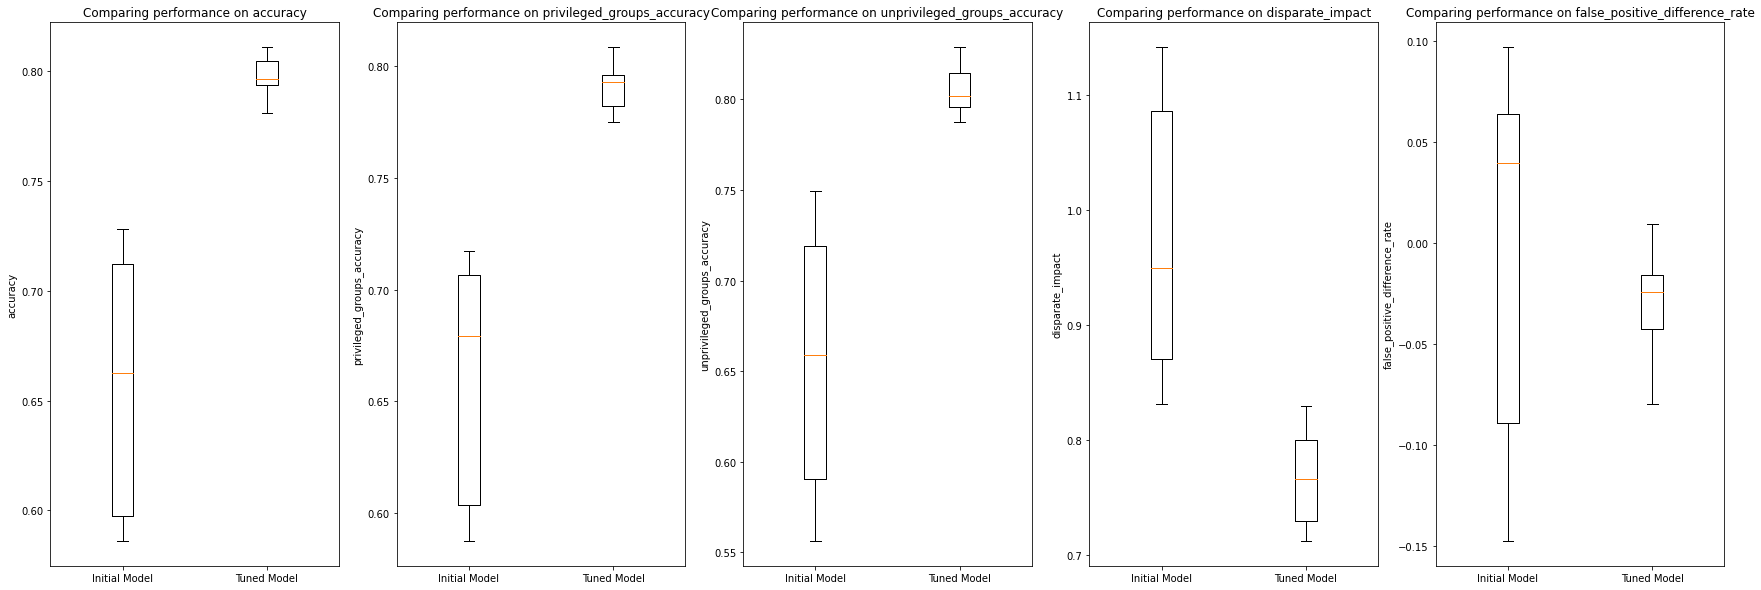

In [25]:
#create 5 graphs 
fig, axs = plt.subplots(1,5, figsize=(30,10))

for i in range(len(metric_list)):
    metric = metric_list[i]
    ax = axs[i] 
    pcm = ax.boxplot([initial_metrics[metric], tuned_metrics[metric]], labels = ['Initial Model', 'Tuned Model'])
    ax.title.set_text('Comparing performance on ' + metric)
    ax.set_ylabel(metric)

plt.show()

# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

In [ ]:
#tuned_metrics 
#uncomment the above to analyze which parameters did the best out of our 5 metrics of interest

#best performance on test set data was run 4, which had parameters of max_depth = 10 and n_estimators = 20
output_dict[4]

In [ ]:
#create 10 data points to plot performance over repair level
repair_list = np.linspace(0,1,10)


In [ ]:
def repair_tuned_rf(repair_list):
  #initialize seed values used in data splitting
    ClassificationMetric_list = []
    seed_list = [27,100,65,12345,59,210398,4231,45,1,98753]
    for i in range(len(repair_list)):
        repair = DisparateImpactRemover(repair_list[i],sensitive_attribute='SEX')
        train_orig, test_orig = dataset_orig.split([0.8], shuffle=True , seed= seed_list[i])


  #apply preprocessing to our data
        repair_train = repair.fit_transform(train_orig)
        repair_test = repair.fit_transform(test_orig)
  
  #create dataframe objects 
        repair_train_orig_df, _ = repair_train.convert_to_dataframe()
        repair_test_orig_df, _ = repair_test.convert_to_dataframe()

  #create vectors for base and tuned models

        x_base_train =  repair_train_orig_df.drop(target, axis=1)
        x_base_test  = repair_test_orig_df.drop(target, axis=1)
        y_base_train = repair_train_orig_df.PINCP
        y_base_test  = repair_test_orig_df.PINCP


        #replicate our best predictor
        tuned_predictor = Pipeline(
              steps=[
                    #feature engineering component 
                  ("preprocessor", ColumnTransformer(transformers=[
                                                        # we use selector to indentify features based on its data type
                                                        # Normalize numerical features
                                                        ("num", MinMaxScaler(), selector(dtype_exclude="category")), 
                                                        # Encoding (transforming) categorical features to what understandable by the model
                                                        ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                                      ]
                                                    )
                  ),
                  # model component
                  #using optimal hyperparameters after RandomSearch CV, determined above
                  ("classifier",RandomForestClassifier(max_depth = 10, n_estimators=20),
                  ),
              ])

        #fit tuned model
        tuned_predictor.fit(x_base_train, y_base_train)

        #predict tuned model onto dataframe

        tuned_pred_df = test_orig_df.copy()
        tuned_pred_df[target] = tuned_predictor.predict(x_base_test)

        #create AIF360 objects
        preds_aif360 = StandardDataset(tuned_pred_df, label_name=target, protected_attribute_names=[protected_attr], 
                    privileged_classes=[[1]], favorable_classes=[1])
        orig_aif360 = StandardDataset(test_orig_df, label_name=target, protected_attribute_names=[protected_attr], 
                    privileged_classes=[[1]], favorable_classes=[1])

        #store results
        ClassificationMetric_list.append(ClassificationMetric(orig_aif360, preds_aif360, unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups))

    return(ClassificationMetric_list)



In [ ]:
#run the func
repair_metric_list = repair_tuned_rf(repair_list)

In [ ]:
#compute 5 metrics of interest
repair_metrics = compute_metric_lists(repair_metric_list,metric_list, True)

In [ ]:
#create a new key for the repair level itself
repair_metrics['repair_level'] = repair_list
#repair_metrics

In [ ]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, x_label='Repair level'):
  '''Creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
    plt.plot(repair_levels, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

    # Create labels, etc. 
    plt.xlabel(x_label)
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

In [ ]:
#plot metrics according to repair level
fig, axs = plt.subplots(1,5, figsize=(20,10))

for i in range(len(metric_list)):
    metric = metric_list[i]
    ax = axs[i] 
    pcm = ax.plot(repair_list, repair_metrics[metric], color='#0384fc', linewidth=3, label=metric)
    ax.title.set_text('Repair level vs ' + metric)
    ax.set_ylabel(metric)

plt.show()

### Apply pre-processing techniques to the dataset, then re-train the models with the optimal hyperparameters from part **b**

In [ ]:
def prejudice_remover(eta_list):

  #initialize seed values used in data splitting

    ClassificationMetric_list = []
    seed_list = [27,100,65,12345,59,210398,4231,45,1,98753][0:9]

  #for 9 iterations,

    for i in range(len(eta_list)):

        #split data into train/test
        train_orig, test_orig = dataset_orig.split([0.8], shuffle=True , seed= seed_list[i])

        #create PrejudiceRemover Object with value of eta
        PrejudiceRemoverObj = PrejudiceRemover(eta_list[i])  


        #create dataframe objects 
        train_orig_df, _ = train_orig.convert_to_dataframe()
        test_orig_df, _ = test_orig.convert_to_dataframe()

        #create a preprocess object
        preprocessing = ColumnTransformer(
        [("scaler", MinMaxScaler(), [0, 1])],
        remainder="passthrough")

        #create binarylabeldataset objects for train/test

        BinaryTrainDataset = BinaryLabelDataset(favorable_label=1,
          unfavorable_label=0,
          df=train_orig_df,
          label_names=[target],
          protected_attribute_names=[protected_attr])

        BinaryTestDataSet = BinaryLabelDataset(favorable_label=1,
          unfavorable_label=0,
          df=test_orig_df,
          label_names=[target],
          protected_attribute_names=[protected_attr])


        #preprocess train/test datasets
        BinaryTrainDataset.features = preprocessing.fit_transform(BinaryTrainDataset.features)
        BinaryTestDataSet.features = preprocessing.transform(BinaryTestDataSet.features)

        #fit the data onto the training data

        fit = PrejudiceRemoverObj.fit(BinaryTrainDataset)

        #store predictions into a dataframe
        unprejudiced_df = test_orig_df.copy()
        unprejudiced_df[target] = fit.predict(BinaryTestDataSet).labels

        #create aif360 objects
        preds_aif360 = StandardDataset(unprejudiced_df, label_name=target, protected_attribute_names=[protected_attr], 
                    privileged_classes=[[1]], favorable_classes=[1])
        orig_aif360 = StandardDataset(test_orig_df, label_name=target, protected_attribute_names=[protected_attr], 
                    privileged_classes=[[1]], favorable_classes=[1])

        #store metrics
        ClassificationMetric_list.append(ClassificationMetric(orig_aif360, preds_aif360, unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups))

    return(ClassificationMetric_list)



# Problem 2, Part (d) 
### **Prejudice Remover In-Processing intervention**



### Fit new models using the Prejudice Remover technique

In [ ]:
#create eta list to remove prejudice, run func
eta_list = np.linspace(0,1,9)

unprejudiced_models = prejudice_remover(eta_list)


In [ ]:
#compute metrics
unprejudiced_metrics = compute_metric_lists(unprejudiced_models, metric_list, True)

In [ ]:
#plot performance across eta levels
fig, axs = plt.subplots(1,5, figsize=(20,10))

for i in range(len(metric_list)):
    metric = metric_list[i]
    ax = axs[i] 
    pcm = ax.plot(eta_list, unprejudiced_metrics[metric], color='#0384fc', linewidth=3, label=metric)
    ax.title.set_text('Eta level vs ' + metric)
    ax.set_ylabel(metric)

# Problem 2, Part (e) 
### **Reject Option Post-Processing intervention**

### Using the same random forest models as before, apply the post-processing technique to your results and compare

In [ ]:
def ROC_rf():
  ###steps:
      ##split data into train/val/test
      #train data using optimally tuned random forest
      #pass trained model into ROC classifer, validating on validation dataset
      #test new model after post-processing on test dataset

  #initialize seed values used in data splitting
 
    seed_list = [27,100,65,12345,59,210398,4231,45,1,98753]

  #create gridSearchCV inputs
  
    final_dict = {}
    for i in range(len(seed_list)):
        final_dict[i] = {}
        #create splits for train,validation and test datasets
        train_orig, test_orig = dataset_orig.split([0.8], shuffle=True , seed= seed_list[i])
        train_new, val_new = train_orig.split([.875],shuffle=True, seed = seed_list[i])

        #create dataframe objects 
        train_orig_df, _ = train_orig.convert_to_dataframe()
        train_new_df,_ =train_new.convert_to_dataframe()
        val_new_df, _ = val_new.convert_to_dataframe()
        test_orig_df, _ = test_orig.convert_to_dataframe()

        #create vectors for base and tuned models

        x_base_train, x_base_test = train_orig_df.drop(target, axis=1), test_orig_df.drop(target, axis=1)
        y_base_train, y_base_test= train_orig_df.PINCP,  test_orig_df.PINCP


        x_val_train, x_val_test = train_new_df.drop(target, axis=1), val_new_df.drop(target, axis=1)
        y_val_train, y_val_test = train_new_df.PINCP, val_new_df.PINCP

        #create splits for hyperparameter tuning
        split_index = [-1 if x in x_val_train.index else 0 for x in x_base_train.index]
        pds = PredefinedSplit(test_fold = split_index)
        params_list= []

        for k in sorted(output_dict[i]['params'].keys()):
            params_list.append(output_dict[i]['params'][k])


    #create pipeline object
        tuned_predictor = Pipeline(
            steps=[
                  #feature engineering component 
                ("preprocessor", ColumnTransformer(transformers=[
                                                      # we use selector to indentify features based on its data type
                                                      # Normalize numerical features
                                                      ("num", MinMaxScaler(), selector(dtype_exclude="category")), 
                                                      # Encoding (transforming) categorical features to what understandable by the model
                                                      ("cat", OneHotEncoder(handle_unknown="ignore"), selector(dtype_include="category")),
                                                    ]
                                                  )
                ),
                # model component
                ("classifier",RandomForestClassifier(max_depth = params_list[0], n_estimators=params_list[1]),
                ),
            ])

        #fit optimized rf on training data
        tuned_predictor.fit(x_base_train, y_base_train)
        pos_ind = np.where(tuned_predictor.classes_ == train_orig.favorable_label)[0][0]

        #predict on validation data
        valid_pred_BLD = val_new.copy()


        valid_pred_BLD.scores = tuned_predictor.predict_proba(x_val_test)[:,pos_ind].reshape(-1,1)
        fav_inds = valid_pred_BLD.scores > .5

        valid_pred_BLD.labels[fav_inds], valid_pred_BLD.labels[~fav_inds] = val_new.favorable_label, val_new.unfavorable_label


        #validate optimal ROC parameters on validation dataset
        ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups,
                                         low_class_thresh = 0.01,
                                         high_class_thresh =.99,
                                         num_class_thresh = 10,
                                         num_ROC_margin=10
                                         )

        ROC.fit(val_new,valid_pred_BLD)

        #store decision boundaries and ROC margin
        best_class_threshold = ROC.classification_threshold 
        best_margin = ROC.ROC_margin

        final_dict[i]['class_threshold'] = best_class_threshold
        final_dict[i]['margin'] = best_margin

        #predict on test datasets

        dataset_orig_test_pred = test_orig.copy()
        dataset_orig_test_pred.scores = tuned_predictor.predict_proba(x_base_test)[:,pos_ind].reshape(-1,1)

        #transfrom scores into labels using calcualted decision boundary
        fav_inds = dataset_orig_test_pred.scores > best_class_threshold
        dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
        dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

        #predict data on test set
        ROC_Test = ROC.predict(dataset_orig_test_pred)

        orig_aif360 = StandardDataset(test_orig_df, label_name=target, protected_attribute_names=[protected_attr], 
                    privileged_classes=[[1]], favorable_classes=[1])

        #store results
        final_dict[i]['metric_list']=ClassificationMetric(test_orig, ROC_Test, unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
    return(final_dict)
  

In [ ]:
ROC_list = ROC_rf()

In [ ]:
ROC_metric_list = ['accuracy', 'privileged_groups_accuracy', 'unprivileged_groups_accuracy', 'disparate_impact', 'false_positive_difference_rate',
 'class_threshold', 'margin',]
post_processed_metrics = compute_metric_lists(ROC_list, ROC_metric_list, False)[1:][0]


In [ ]:
#plot performance across 5 metrics for ROC, tuned and base random forests
fig, axs = plt.subplots(1,5, figsize=(20,10))

for i in range(len(metric_list)):
    metric = metric_list[i]
    ax = axs[i] 
    pcm = ax.boxplot([post_processed_metrics[metric],tuned_metrics[metric],repair_metrics[metric]],
                   labels = ['PostProcessed Model', 'Tuned Model', 'repaired_model'])
    #ax.title.set_text('Eta level vs ' + metric)
    ax.set_ylabel(metric)